# XGBoost-Decision-Stumps-to-Linear
This notebook shows how to convert boosted decision stumps to a linear model structure. <br> Note that the loss function in this example is squared error, it requires more work for poisson or gamma loss where a different link function is involved.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
%matplotlib inline

## Build xgboost model on Boston house price dataset
Keep max_depth = 1 to ensure we are building decision stumps, i.e. each tree has a single split for a single variable.

In [2]:
boston = load_boston()
dtrain = xgb.DMatrix(data = boston.data, label = boston.target)
param = {'max_depth': 1, 
         'eta': 1, 
         'silent': 1, 
         'objective': 'reg:linear'}
num_round = 100
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtrain)
preds[:10]

array([25.988674, 19.886593, 31.815113, 36.119003, 32.64179 , 27.600332,
       21.735994, 19.486586, 15.796878, 18.609497], dtype=float32)

In [3]:
boston_data_df = pd.DataFrame(boston.data)
boston_data_df.columns = boston.feature_names
boston_data_df["target"] = boston.target
boston_data_df["y_hat"] = preds
boston_data_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,y_hat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,25.988674
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,19.886593
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,31.815113
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,36.119003
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,32.641788


## Dump model structure to .txt file

In [4]:
bst.dump_model('dump.raw.txt')

## Function to read model dump

In [5]:
def read_dump(file):
    """
    Reads an xgboost model dump .txt file and parses it into a tabular structure.
    :param file: xgboost model dump .txt file
    :return: pd.DataFrame, with columns tree, node, left, right, missing, split_var, split_point, prediction
    """
    with open(file) as f:

        lines = f.readlines()
    
    tree_no = -1
    
    lines_list = []
    
    for i in range(len(lines)):
        
        # if line is a new tree
        if lines[i][:7] == 'booster':
            
            tree_no += 1
        
        # else if node row
        else:
        
            line_dict = {}
        
            # remove \n from end and any \t from start
            node_str = lines[i][:len(lines[i])-1].replace('\t', '')
            
            line_dict['tree'] = tree_no
            
            # get the node number before the :
            line_dict['node'] = int(node_str.split(':')[0])
            
            # else if leaf node
            if ':leaf=' in lines[i]:
                
                # get node prediction after the =
                line_dict['prediction'] = float(node_str.split('=')[1])

            # else non terminal node
            else:
                
                # remove the node number and :, then split by space
                node_str_split = node_str.split(':')[1].split(' ')
                
                # remove square brackets and split by <
                node_str_split[0] = node_str_split[0].replace('[', '').replace(']', '').split('<')
                
                # extract split variable name before the <
                line_dict['split_var'] = node_str_split[0][0]
                
                # extract split point after the <
                line_dict['split_point'] = float(node_str_split[0][1])
                
                #print(node_str_split)
                
                # split the child nodes
                node_str_split[1] = node_str_split[1].split(',')
                
                # get the child nodes
                line_dict['left'] = int(node_str_split[1][0].split('=')[1])
                line_dict['right'] = int(node_str_split[1][1].split('=')[1])
                line_dict['missing'] = int(node_str_split[1][2].split('=')[1])
                
            lines_list = lines_list + [line_dict]
    
    lines_df = pd.DataFrame.from_dict(lines_list)
    
    col_order = ['tree', 'node', 'left', 'right', 'missing', 'split_var', 'split_point','prediction']
    
    # reorder columns
    lines_df = lines_df.loc[:,col_order]
    
    lines_df.sort_values(['tree', 'node'], inplace = True)
    
    return(lines, lines_df)

## Read in model structure
From the dumped model structure we can extract terminal node predictions, split variables and split points as well as the child / parent node relationship for each tree.

In [6]:
lines, model_structure = read_dump('dump.raw.txt')
lines[:10]

['booster[0]:\n',
 '0:[f12<9.725] yes=1,no=2,missing=1\n',
 '\t1:leaf=29.092\n',
 '\t2:leaf=16.7864\n',
 'booster[1]:\n',
 '0:[f5<7.437] yes=1,no=2,missing=1\n',
 '\t1:leaf=-0.878953\n',
 '\t2:leaf=15.0045\n',
 'booster[2]:\n',
 '0:[f12<19.83] yes=1,no=2,missing=1\n']

In [7]:
model_structure.head(10)

,tree,node,left,right,missing,split_var,split_point,prediction
0,0,0,1.0,2.0,1.0,f12,9.725,NaN
1,0,1,NaN,NaN,NaN,NaN,NaN,29.092000
2,0,2,NaN,NaN,NaN,NaN,NaN,16.786400
3,1,0,1.0,2.0,1.0,f5,7.437,NaN
4,1,1,NaN,NaN,NaN,NaN,NaN,-0.878953
5,1,2,NaN,NaN,NaN,NaN,NaN,15.004500
6,2,0,1.0,2.0,1.0,f12,19.830,NaN
7,2,1,NaN,NaN,NaN,NaN,NaN,0.747552
8,2,2,NaN,NaN,NaN,NaN,NaN,-4.000900
9,3,0,1.0,2.0,1.0,f12,9.725,NaN


## Function to convert parsed tree structure into linear model

In [8]:
def stumps_to_linear(model_structure):
    """
    Reads parsed xgboost model structure and returns a dict of linear model structure for each variable in the model.
    :param model_structure: parsed xgboost model structure
    :return: dict, of pd.DataFrames (one for each variable) showing predicted value for linear model structure
    """
    assert model_structure['node'].max() == 2, 'trees should be stumps i.e. max depth = 1'
    
    top_nodes = model_structure.loc[model_structure['node'] == 0, :]
    
    # count trees splitting each variable
    variable_counts = top_nodes['split_var'].value_counts()
    
    linear_structure = {}
    
    # loop through each variable in the model
    for i in range(variable_counts.shape[0]):
        
        var_name = variable_counts.index[i]
        
        # select rows 
        variable_nodes = model_structure.loc[model_structure['split_var'] == var_name, :]
        
        # get unique split points and add Inf for everything gt the last split point to be lt
        upper_bounds = np.concatenate([variable_nodes['split_point'].sort_values().unique(), 
                                       np.array([float('Inf')])])
        
        lower_bounds = np.concatenate([np.array([-float('Inf')]), 
                                       variable_nodes['split_point'].sort_values().unique()])
        
        # put in DataFrame
        linear_structure_var = pd.DataFrame({'lower_bounds': lower_bounds,
                                             'upper_bounds': upper_bounds})
        
        # initially set the predicted value for the range of the variable to 0
        linear_structure_var['prediction'] = 0
        
        #linear_structure_var['variable'] = var_name
        
        # number of split points (including Inf level)
        n_bins = linear_structure_var.shape[0]
        
        # loop through each tree using the ith variable
        for tree_no, split_point in zip(variable_nodes['tree'], variable_nodes['split_point']):
            
            # get prediction for the current tree if lt the split value
            lt_pred = model_structure.loc[(model_structure['tree'] == tree_no) & (model_structure['node'] == 1), 
                                          'prediction'].values[0]
            
            # get prediction for the current tree if gt or equal to the split value
            gt_pred = model_structure.loc[(model_structure['tree'] == tree_no) & (model_structure['node'] == 2), 
                                          'prediction'].values[0]

            # find bins less than or equal to the split point 
            lte_idx = linear_structure_var['upper_bounds'] <= split_point
            
            lte_bins = sum(lte_idx)
            
            # put predicted values above and below split point into list
            tree_prediction = [lt_pred] * lte_bins + [gt_pred] * (n_bins - lte_bins)
            
            # add on predicted values for range of variable (for current tree)
            linear_structure_var['prediction'] = linear_structure_var['prediction'] + tree_prediction

        linear_structure[var_name] = linear_structure_var
            
    return(linear_structure)

## Get linear model structure
The output of the stumps_to_linear function is a dict containing binned predictions for each variable in the model. This is represented in a DataFrame where lower_bounds and upper_bounds show the bin edges and prediction is the predicted value for the bin. Note that upper_bounds are not inclusive.

In [9]:
linear_structure = stumps_to_linear(model_structure)
linear_structure['f12']

,lower_bounds,upper_bounds,prediction
0,-inf,2.965000,30.037382
1,2.965000,3.210000,28.690709
2,3.210000,4.055000,29.873573
3,4.055000,4.650000,29.153260
4,4.650000,5.155000,27.620103
5,5.155000,6.725000,25.579644
6,6.725000,7.475000,24.894776
7,7.475000,9.335000,24.340678
8,9.335000,9.725000,24.743990
9,9.725000,14.230000,20.912158


In [10]:
list(linear_structure.keys())

['f12',
 'f7',
 'f5',
 'f0',
 'f4',
 'f11',
 'f10',
 'f2',
 'f6',
 'f1',
 'f9',
 'f3',
 'f8']

## Plot model structure
Below plot the following for each explantory variable by the bins defined by the xgboost model splits; 
- average observed (pink)
- average fitted or predicted values (dark green)
- number of observations by bin (yellow)
- model coefficient for the bin (light green)

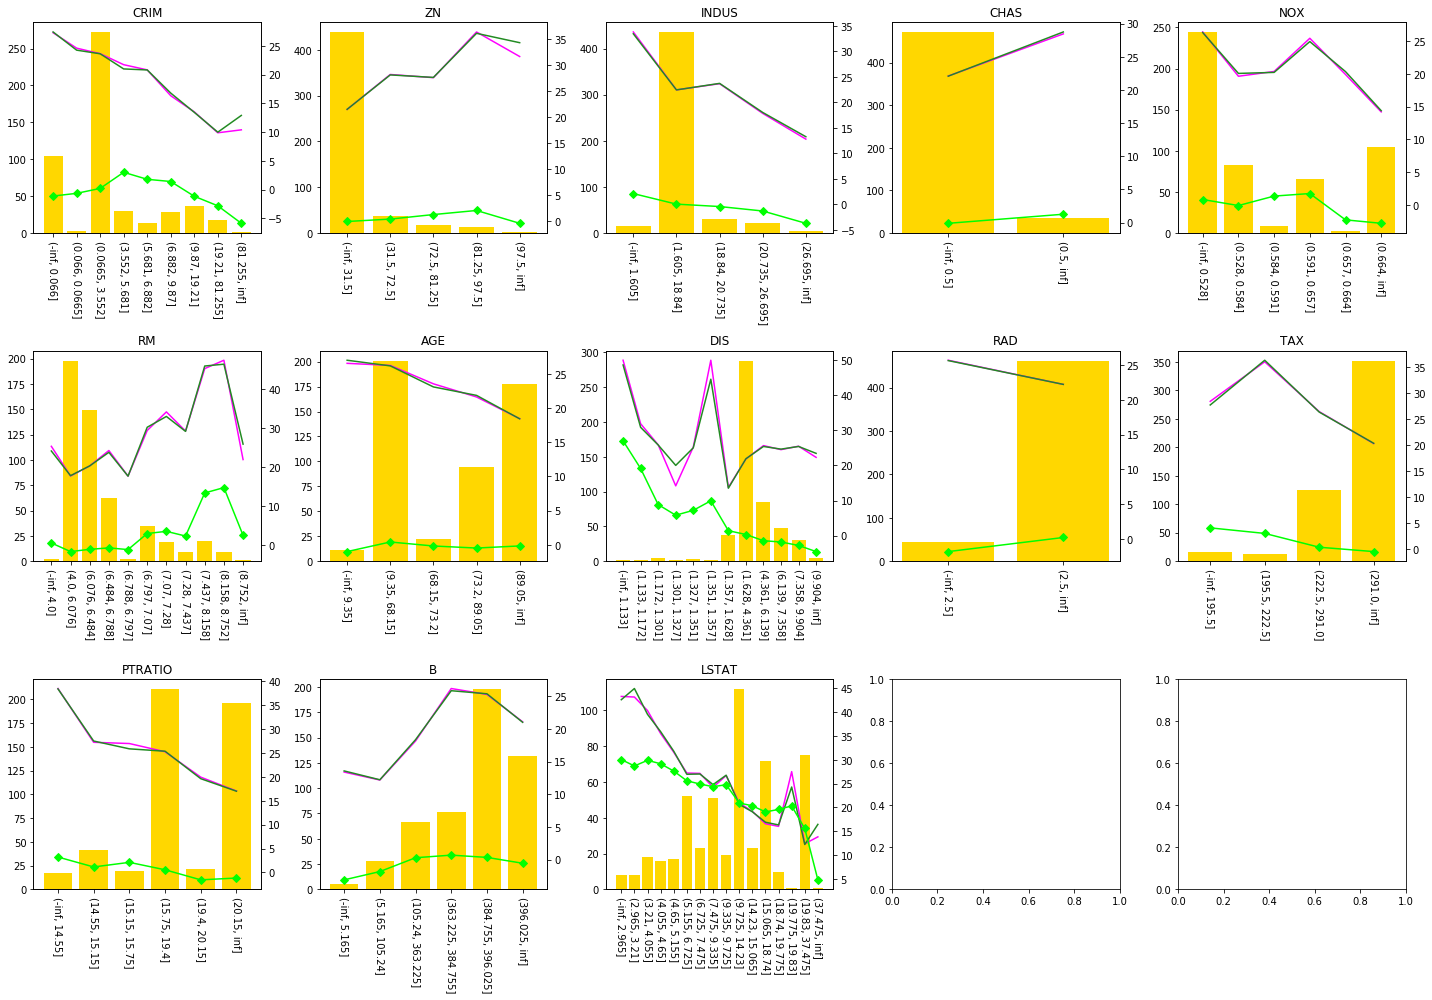

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 14))
for i in range(len(boston.feature_names)):
    
    row = i % 5
    col = int(i / 5)
    
    by_col = boston.feature_names[i]
    
    xgb_col = 'f' + str(i)
    
    # get the output from stumps_to_linear
    linear_str = linear_structure[xgb_col]
    
    # bin the by_col variable into equal width buckets
    cut = pd.cut(boston_data_df[by_col], 
                 bins = list(linear_structure[xgb_col]['lower_bounds'].values) + [float('Inf')], 
                 include_lowest = True)
    
    # calculate mean observed, fitted and count by bins
    f = {'target': ['mean'], 'y_hat': ['mean'], by_col: ['count']}
    bin_values = boston_data_df.groupby(cut).agg(f)
    
    # plot bin counts on first x axis 
    axes[col, row].bar(np.arange(bin_values.shape[0]), 
                       bin_values.iloc[:,2].reset_index(drop = True),
                       color = 'gold')
    
    # add title
    axes[col, row].set_title(by_col)
    
    # add labels to x axis
    plt.sca(axes[col, row])
    plt.xticks(np.arange(bin_values.shape[0]), bin_values.index, rotation = 270)
    
    # add second x axis
    ax2 = axes[col, row].twinx()
    
    # plot average observed on the 2nd axis in pink
    ax2.plot(bin_values.iloc[:,0].reset_index(drop = True).dropna().index,
             bin_values.iloc[:,0].reset_index(drop = True).dropna(),
             color = 'magenta', 
             linestyle = '-')
    
    # plot average observed on the 2nd axis in green
    ax2.plot(bin_values.iloc[:,1].reset_index(drop = True).dropna().index,
             bin_values.iloc[:,1].reset_index(drop = True).dropna(),
             color = 'forestgreen', 
             linestyle = '-')
    
    # plot model coefficients / bin prediction
    ax2.plot(bin_values.iloc[:,1].reset_index(drop = True).dropna().index,
             linear_str['prediction'],
             color = 'lime', 
             linestyle = '-',
             marker = 'D')
    
plt.tight_layout()